In [ ]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
local
stop final relax at some point


stop final relax at some point


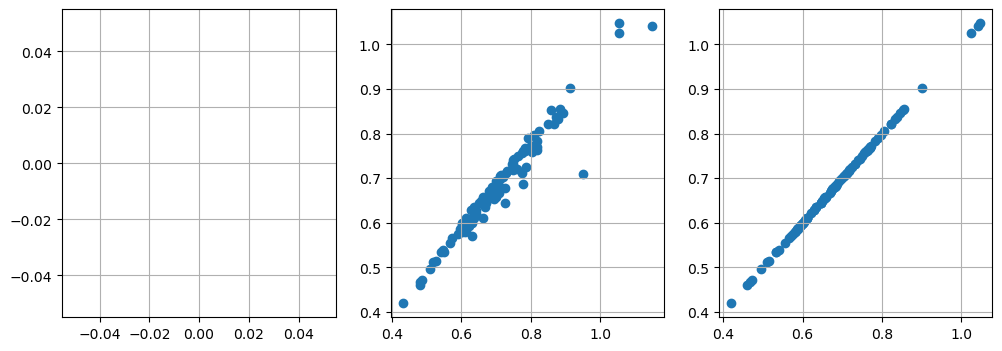

Generation 0, Trees 40, Best cost: 0.41977069, Est: 1.04942675, h: 6.478971


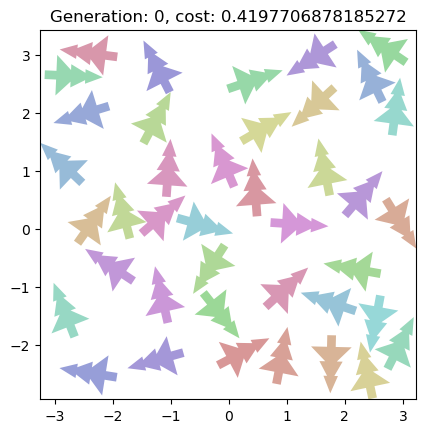

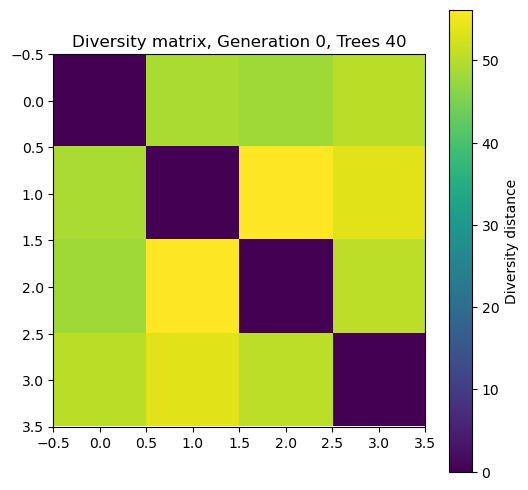

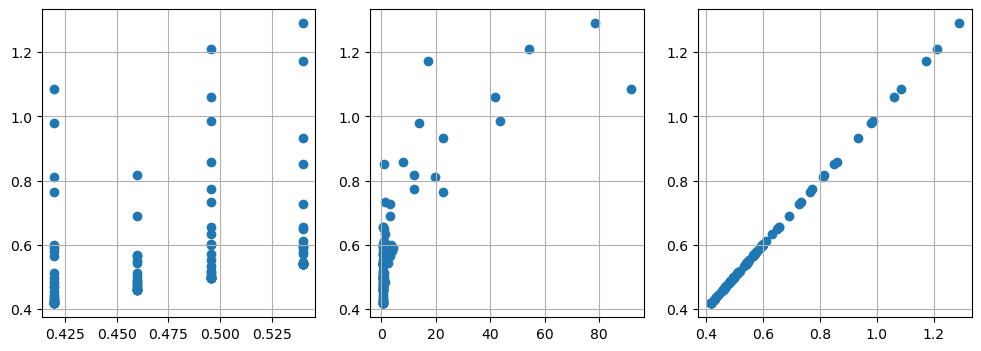

Generation 1, Trees 40, Best cost: 0.41766500, Est: 1.04416256, h: 6.462701


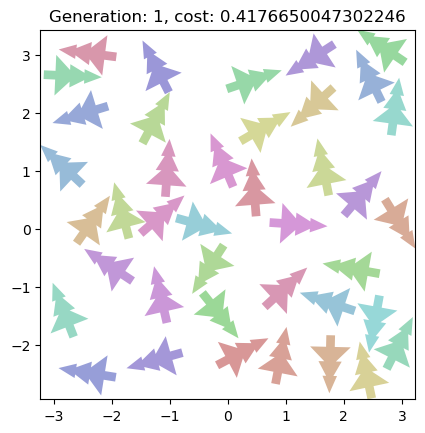

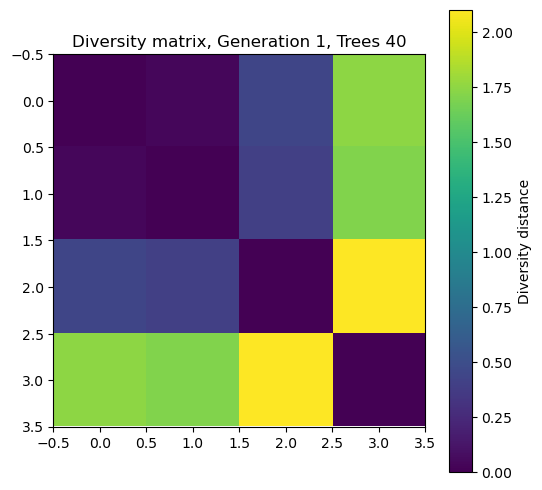

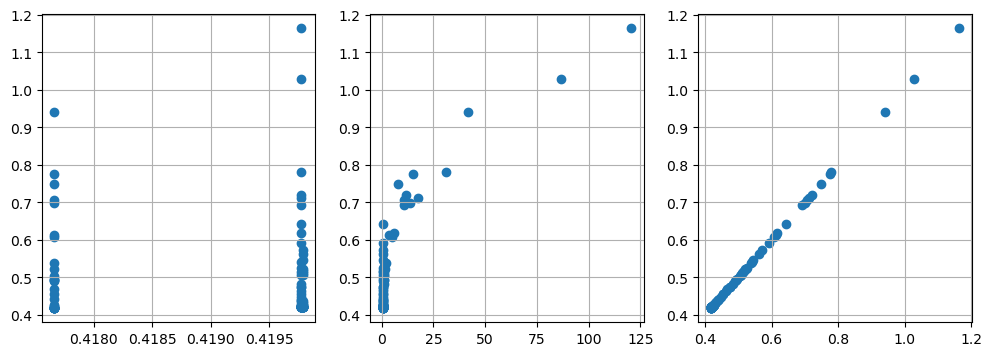

Generation 2, Trees 40, Best cost: 0.41766500, Est: 1.04416256, h: 6.462701


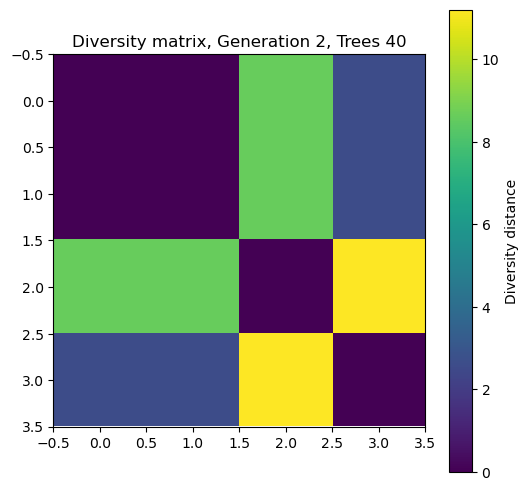

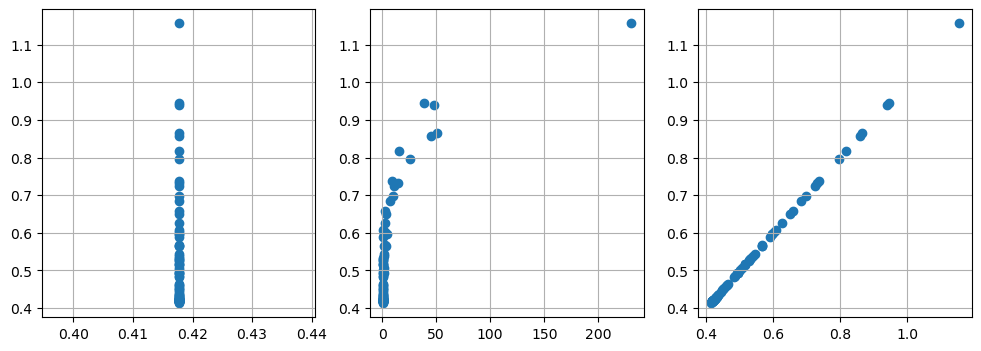

Generation 3, Trees 40, Best cost: 0.41276085, Est: 1.03190212, h: 6.405068


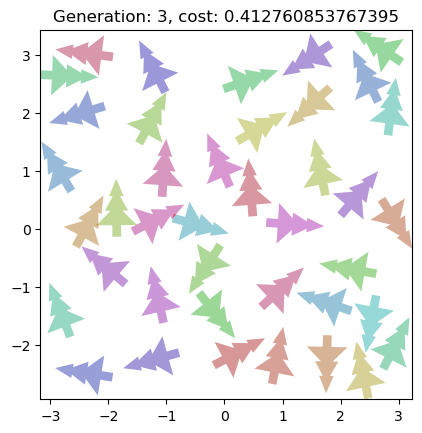

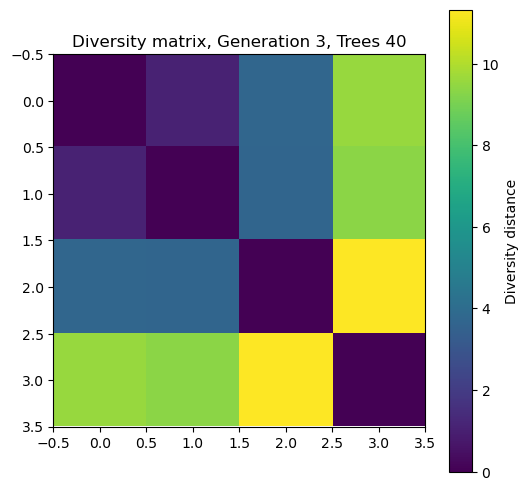

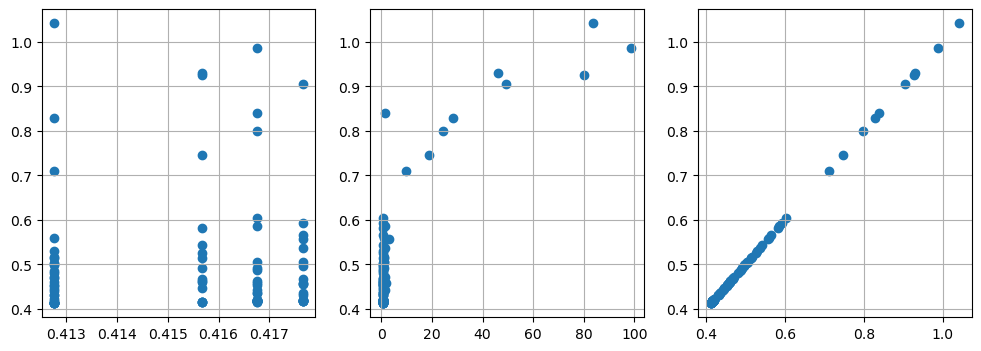

Generation 4, Trees 40, Best cost: 0.41276085, Est: 1.03190212, h: 6.405068


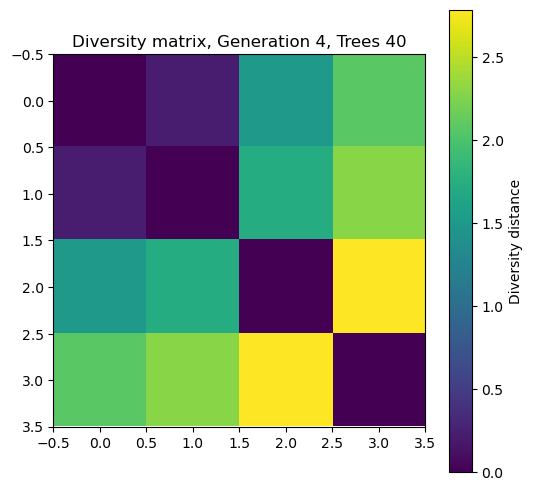

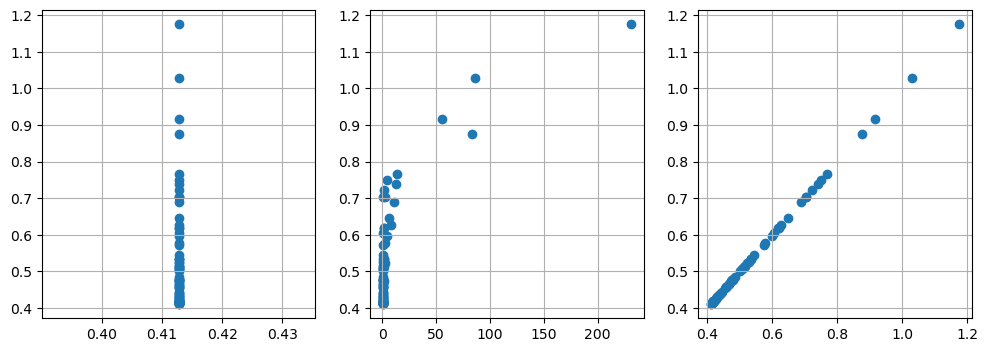

In [ ]:
importlib.reload(pack_ga)
fastMode = False
runner = pack_ga.GA()
runner.N_trees_to_do = np.array([40])
runner.plot_fitness_predictors = True
runner.plot_diversity_matrix = True
runner.n_generations = 300
if fastMode:
    runner.initializer.jiggler.duration_compact /= 10
    runner.initializer.jiggler.plot_interval = None
    runner.initializer.jiggler.n_rounds = 1    
    runner.rough_relaxers[0].n_iterations= 0
    runner.fine_relaxers = []
    runner.n_generations = 5
    runner.population_size = 100
    runner.selection_size = [1,2,5,10]
    kgs.debugging_mode = 2
kgs.profiling=False
runner.run()